<a href="https://colab.research.google.com/github/hananather/Projects/blob/master/Backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We begin by creating a **Value** class.
What is the point of creating this class?
- This class will be the building block for creating **expresion graph**
- when we take these 'value' objects and apply a mathematical operation such as addition or multiplication, we create a **new** value object which contains the childern and operation that created it.

- The way we compute the partial derivate will be different for every value object depending on the operation which was used to create that object
  1. we implement a `self._backward = lambda: None` argument in the constructor so that every value object has a `self._backward` method.
  2. When a new value object is created based some operation involving previous value object(s) (such as addition, or applying the expoential function etc..) `_backward` is also updated based on the operation that was applied.
  3. Calling the `_backward()` function on an object updates the gradients of the childern.
  


For every operator sign, there is an underlying mechanism.

This underlying mechanism is a special method that will be called during the operator action.

This special method is called a magical method.


In [1]:
import math
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other ), '+')

    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __pow__(self,other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self,), f'**{other}')
    def _backward():
      self.grad += other* (self.data ** (other-1)) * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) +1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    self.grad = 1
    for v in reversed(topo):
      v._backward()


  def __radd__(self, other):
    return self + other



In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s |data %.4f |grad %.4f }" % (n.label,n.data,n.grad,), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

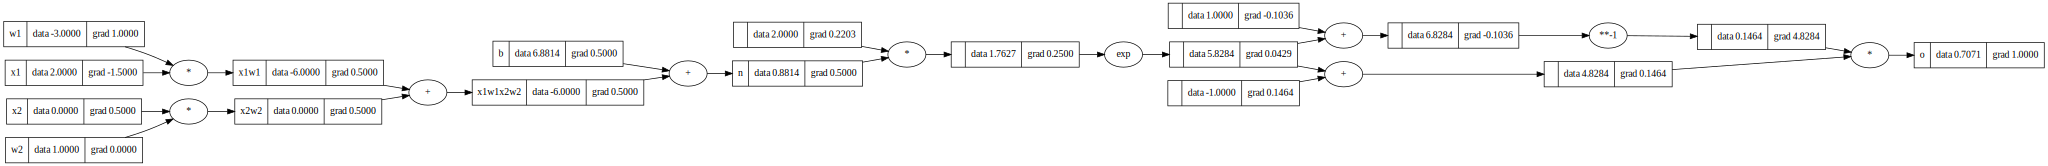

In [23]:
# inputs
x1 = Value(2.0, label ='x1')
x2 = Value(0.0, label='x2')

# weight w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# --
e = (2*n).exp()
o = (e-1)/ (e+1)

o.label = 'o'
o.backward()
draw_dot(o)

This is a recursive algorithm that keeps iterating over the value objects until it reaches a value object that does not have anything in `_prev`.

Micrograd is a sclar valued engine; it would be interesting to extend this..

In [1]:
import torch

In [8]:
x1 = torch.Tensor([2.0]).double()   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())

0.7071066904050358


In [9]:
o.backward()

In [13]:
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

-1.5000003851533106
0.5000001283844369
1.0000002567688737
0.0


Now that we have the machinery to build out complicated mathematical expressions, we can also start building up neural networks.

In [8]:
import math
import random

class Neuron:
   # constructor takes number of inputs and construct a weight
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))